In [2]:
from __future__ import annotations
import jax
import jax.numpy as jnp

import pyhf
import matplotlib.pyplot as plt

from model import make_model
import relaxed

import jaxopt
import optax


pyhf.set_backend("jax", default=True)


def metrics(
    model: pyhf.Model,
    observed_data: jnp.array,
    diff_pars: jnp.ndarray,
) -> jnp.array:
    cls_obs, bestfit_pars = relaxed.hypotest(
        1.0, observed_data, model, init_pars=jnp.array([0.0, 0.0]), return_mle_pars=True
    )
    cov_approx = relaxed.fisher_info_covariance(bestfit_pars, model, observed_data)
    mu_idx, y_idx = model.config.par_order.index("mu"), model.config.par_order.index(
        "bkguncrt"
    )
    mu_uncert2 = cov_approx[mu_idx, mu_idx]
    pull_width_metric2 = (1 - cov_approx[y_idx, y_idx]) ** 2
    gaussianity = relaxed.model_gaussianity(
        model, bestfit_pars, cov_approx, observed_data
    )

    return dict(
        cls_obs=cls_obs,
        mu_uncert2=mu_uncert2,
        pull_width_metric2=pull_width_metric2,
        gaussianity=gaussianity,
    )


def pipeline(pars: jnp.array, data: jnp.array) -> jnp.array:
    model = make_model(pars)
    all_data = jnp.concatenate((data, jnp.array(model.config.auxdata)))
    return jnp.array(list(metrics(model, all_data, pars).values()))

In [19]:
jax.jacrev(pipeline)(jnp.array([-2.0, -2.0]), data=jnp.array([50.0, 50]))

DeviceArray([[ 0.        ,  0.        ],
             [ 0.        ,  0.        ],
             [ 0.        ,  0.        ],
             [-0.02665937, -0.03569677]], dtype=float64)

In [3]:
scales = jnp.array([1, 3, 1.7, 77])


def loss(pars):
    #     return jnp.sum(pipeline(pars, jnp.array([50.,50.]))*scale)
    return jnp.log(jnp.sum(pipeline(pars, jnp.array([50.0, 50.0])) / scales))


jax.value_and_grad(loss)(jnp.array([1.0, 1.0]))

(DeviceArray(0.43001813, dtype=float64),
 DeviceArray([0.00052217, 0.0005665 ], dtype=float64))

In [ ]:
import time

trajectory5 = []

params = jnp.array([-6.432, 2.0])
trajectory5.append(params)

lr = lambda i: 5e-1 if i < 90 else 1e-1
tx = optax.adam(learning_rate=lr)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss)

for i in range(120):
    t0 = time.perf_counter()
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    trajectory5.append(params)
    t1 = time.perf_counter()
    print(f"in {t1-t0:.3f}s, loss step {i}: {loss_val:.4f}, pars = {params}")

in 23.289s, loss step 0: 0.5452, pars = [-5.93200018  1.50000016]
in 22.453s, loss step 1: 0.5176, pars = [-5.43400601  1.00230595]
in 22.779s, loss step 2: 0.4934, pars = [-4.94076441  0.50999385]
in 22.598s, loss step 3: 0.4734, pars = [-4.45629779  0.02751568]
in 22.633s, loss step 4: 0.4576, pars = [-3.98570789 -0.43951766]
in 36.988s, loss step 5: 0.4462, pars = [-3.53454275 -0.88501796]
in 23.895s, loss step 6: 0.4384, pars = [-3.10794738 -1.30334402]
in 23.276s, loss step 7: 0.4335, pars = [-2.7100583  -1.68998963]
in 22.662s, loss step 8: 0.4309, pars = [-2.34393884 -2.04171448]
in 22.585s, loss step 9: 0.4298, pars = [-2.01193905 -2.35622202]
in 33.738s, loss step 10: 0.4299, pars = [-1.71612996 -2.63173336]
in 22.488s, loss step 11: 0.4308, pars = [-1.45852971 -2.86674058]
in 22.548s, loss step 12: 0.4322, pars = [-1.24103218 -3.0600252 ]
in 22.488s, loss step 13: 0.4338, pars = [-1.06511138 -3.21086897]
in 22.544s, loss step 14: 0.4355, pars = [-0.93145563 -3.31931545]
in 22

In [1]:
jnp.save("traj5.npy", jnp.asarray(trajectory5))

NameError: name 'jnp' is not defined

In [109]:
t = np.concatenate((trajectory[:-2], trajectory2, trajectory3, trajectory4))
np.save("t.npy", t)

In [11]:
import numpy as np

dense = 20
num_up, num_down = (dense, dense)

up_grid = np.linspace(-10, 10, num_up)
down_grid = np.linspace(-10, 10, num_down)

uv, dv = np.meshgrid(up_grid, down_grid)

In [14]:
from functools import partial

pipe = partial(pipeline, data=jnp.array([50.0, 50.0]))
values = np.array([pipe(jnp.array(a)) for a in np.vstack([uv.ravel(), dv.ravel()]).T])
np.save("vals.npy", values)

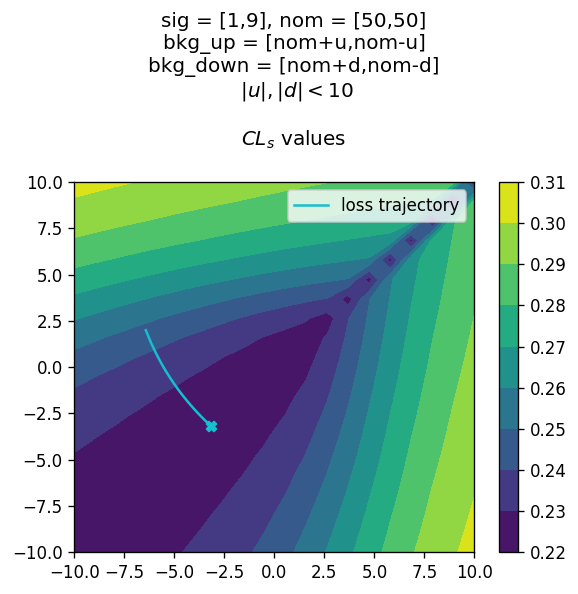

In [53]:
p = plt.contourf(uv, dv, values[:, 0].reshape((dense, dense)))
plt.colorbar(p)
plt.suptitle(
    "sig = [1,9], nom = [50,50]\nbkg_up = [nom+u,nom-u]\nbkg_down = [nom+d,nom-d]\n $|u|, |d|<10$\n\n$CL_s$ values"
)
t = jnp.array(trajectory)
plt.plot(t[:, 0], t[:, 1], color="C9", label="loss trajectory")
# plt.scatter(t[0,0], t[0,1], color='C9',marker="<")
plt.scatter(t[-1, 0], t[-1, 1], color="C9", marker="X")
plt.legend()
plt.tight_layout()

In [63]:
names = ["$CL_s$", r"$\sigma_{mu}^2$", r"$(1-\sigma_{\mathsf{np}})^2$", "gaussianity"]
scale_dict = {k: v for k, v in zip(names, [1, 3, 1.7, 77])}

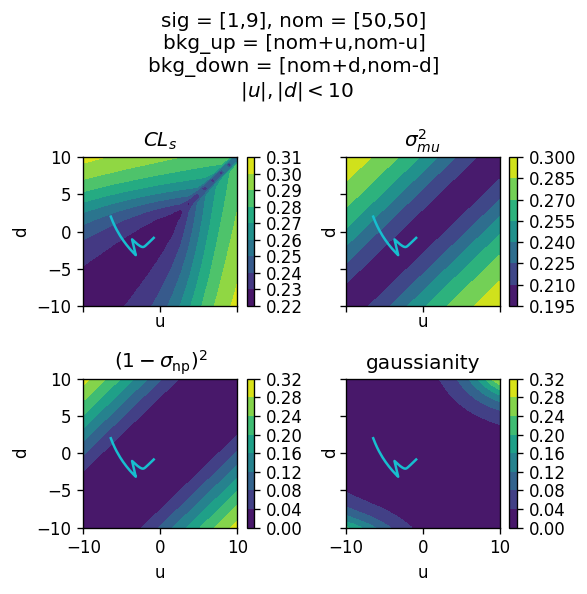

In [141]:
import matplotlib.pyplot as plt

plt.rc("figure", figsize=[5, 5], dpi=120, facecolor="w")

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

for i, (label, ax) in enumerate(
    zip(
        names,
        axs.ravel(),
    )
):
    p = ax.contourf(uv, dv, values[:, i].reshape((dense, dense)) / scale_dict[label])
    plt.colorbar(p, ax=ax)
    ax.set_xlabel("u")
    ax.set_ylabel("d")
    ax.set_title(label)
    ax.plot(t[:-30, 0], t[:-30, 1], color="C9", label="loss trajectory")

plt.suptitle(
    "sig = [1,9], nom = [50,50]\nbkg_up = [nom+u,nom-u]\nbkg_down = [nom+d,nom-d]\n $|u|, |d|<10$"
)
plt.tight_layout()
plt.savefig("contoursw.pdf", bbox_inches="tight")

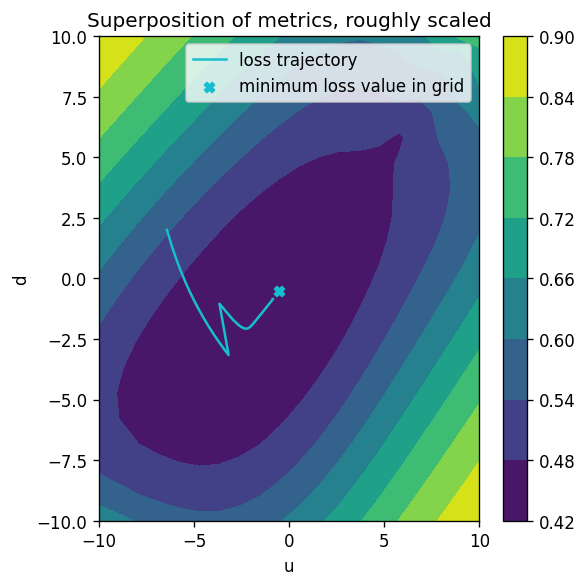

In [138]:
things = []
for i, name in enumerate(names):
    things.append(values[:, i].reshape((dense, dense)) / scale_dict[name])
a = np.asarray(things).sum(axis=0)

p = plt.contourf(uv, dv, a)
plt.colorbar(p)
plt.xlabel("u")
plt.ylabel("d")

pnts = np.vstack([uv.ravel(), dv.ravel()]).T
idx = np.argmin(a.reshape(400), axis=0)
x_min, y_min = pnts[idx]
plt.scatter(x_min, y_min, color="C9", marker="X", label="minimum loss value in grid")
plt.plot(t[:-30, 0], t[:-30, 1], color="C9", label="loss trajectory")

plt.legend()
plt.title("Superposition of metrics, roughly scaled")
plt.tight_layout()
plt.savefig("superposition.pdf", bbox_inches="tight")

In [137]:
t[51] = t[50]

In [133]:
t.shape

(203, 2)

In [140]:
t[:-30]

array([[-6.432     ,  2.        ],
       [-6.17471958,  1.33071556],
       [-5.92009035,  0.74789799],
       [-5.67524072,  0.24641141],
       [-5.44434502, -0.18402894],
       [-5.22940532, -0.55414955],
       [-5.03105858, -0.87346803],
       [-4.84914082, -1.14997466],
       [-4.6830364 , -1.39025765],
       [-4.53188606, -1.59973204],
       [-4.39471294, -1.7828666 ],
       [-4.27049573, -1.94336929],
       [-4.15821503, -2.08433961],
       [-4.05688025, -2.20838582],
       [-3.96554578, -2.317717  ],
       [-3.88331963, -2.41421445],
       [-3.80936921, -2.49949038],
       [-3.74292083, -2.57493041],
       [-3.68326093, -2.64173206],
       [-3.62973382, -2.70093342],
       [-3.5817393 , -2.75343742],
       [-3.53872948, -2.80003133],
       [-3.50020608, -2.84140393],
       [-3.46571688, -2.878159  ],
       [-3.43485158, -2.91082611],
       [-3.40723932, -2.93987128],
       [-3.38254507, -2.96570496],
       [-3.36046653, -2.98868905],
       [-3.34073237,